In [2]:
# Import des librairies
import requests
import re

import openmeteo_requests

import pandas as pd
import numpy as np
import requests_cache
from retry_requests import retry
import time


In [ ]:
df = pd.read_csv('datasets/df_voies_vertes.csv')
df.head()



,Unnamed: 0,Nom,Lien,Début,Fin,Distance,Type voie,Nature voie,Revêtement,Carte,Coordonnées de début,Coordonnées de fin,Coordonnées milieu
0,0,Voie Verte du Chemin d’Encochebérot,https://www.af3v.org/les-voies-vertes/voies/12...,L ISLE JOURDAIN,L ISLE JOURDAIN,"1,6km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.09673702748082', '43.62109781579031')","('1.1131950619939002', '43.6267673096849')","(1.1049660447373602, 43.62393256273761)"
1,1,Voie Verte du canal de Saint-Martory,https://www.af3v.org/les-voies-vertes/voies/12...,CUGNAUX,TOURNEFEUILLE,"2,1km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.32295597087284', '43.5323431084653')","('1.3433622170553097', '43.55502022774329')","(1.333159093964075, 43.5436816681043)"
2,2,Voie Verte de la Masse Pont-du-Casse-Agen,https://www.af3v.org/les-voies-vertes/voies/11...,PONT DU CASSE,AGEN,"2,3km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.6480315531906747', '44.216304129821')","('0.6696608866837562', '44.22602284001947')","(0.6588462199372155, 44.22116348492023)"
3,3,Voie Verte des trois ponts Castelnau d’Estréte...,https://www.af3v.org/les-voies-vertes/voies/12...,CASTELNAU D ESTRETEFONDS,FRONTON,"3,2km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.35618301280646', '43.76616910015008')","('1.3659247959472003', '43.78084206988599')","(1.3610539043768302, 43.773505585018036)"
4,4,Voie Verte des Berges de l'Ill à Mulhouse,https://www.af3v.org/les-voies-vertes/voies/13...,MULHOUSE,SAUSHEIM,"3,3km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('7.34639', '47.773977')","('7.362202', '47.79706')","(7.354296, 47.7855185)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            321 non-null    int64 
 1   Nom                   321 non-null    object
 2   Lien                  321 non-null    object
 3   Début                 321 non-null    object
 4   Fin                   321 non-null    object
 5   Distance              321 non-null    object
 6   Type voie             321 non-null    object
 7   Nature voie           315 non-null    object
 8   Revêtement            317 non-null    object
 9   Carte                 321 non-null    object
 10  Coordonnées de début  321 non-null    object
 11  Coordonnées de fin    321 non-null    object
 12  Coordonnées milieu    321 non-null    object
dtypes: int64(1), object(12)
memory usage: 32.7+ KB


In [19]:
def solar_info_annuel(coord_tuple):
    coord_string = str(coord_tuple)
    coord_string = coord_string.strip('()')  # Retire les parenthèses si présentes
    lon, lat = map(float, coord_string.split(','))

    # Délai de 1-2 secondes entre chaque requête
    time.sleep(1.5)
    
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)

    # Paramètres à renseigner
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"2024-01-01",
        "end_date": f"2024-12-31",
        "daily": ["sunshine_duration", "temperature_2m_mean"],
        "hourly": "shortwave_radiation",
        "timezone": "Europe/Berlin"
    }
    responses = openmeteo.weather_api(url, params=params)

    response = responses[0]
    

    # Process hourly data
    hourly = response.Hourly()
    hourly_shortwave_radiation = hourly.Variables(0).ValuesAsNumpy()

    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["shortwave_radiation"] = hourly_shortwave_radiation

    hourly_dataframe = pd.DataFrame(data = hourly_data)


    # Nettoyage pour exploitation des données du df Hourly
    hourly_dataframe['month'] = hourly_dataframe['date'].dt.month_name(locale='English')
    hourly_dataframe['month_num'] = hourly_dataframe['date'].dt.month

    hourly_dataframe = hourly_dataframe.iloc[2:]

    df_ghi = hourly_dataframe.groupby(['month', 'month_num']).agg(
        ghi_mean_W_m2=('shortwave_radiation', 'mean')
    )

    df_ghi = df_ghi.sort_values(by='month_num')


    # Process daily data
    daily = response.Daily()
    daily_sunshine_duration = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_mean = daily.Variables(1).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["sunshine_duration"] = daily_sunshine_duration
    daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

    daily_dataframe = pd.DataFrame(data = daily_data)


    # Nettoyage pour exploitation des données du df daily
    daily_dataframe['sunshine_duration_hours'] = daily_dataframe['sunshine_duration'] / 3600
    daily_dataframe.drop(columns='sunshine_duration', inplace=True)

    daily_dataframe = daily_dataframe.iloc[1:]

    daily_dataframe['month'] = daily_dataframe['date'].dt.month_name(locale='English')
    daily_dataframe['month_num'] = daily_dataframe['date'].dt.month
    daily_dataframe['days_in_month'] = daily_dataframe['date'].dt.daysinmonth



    df_weather = daily_dataframe.groupby(['month', 'month_num']).agg(
        temp_mean_c=('temperature_2m_mean', 'mean'),
        sunshine_duration_mean_hour=('sunshine_duration_hours', 'mean'),
        days_in_month=('days_in_month', 'first')  
    )


    df_weather = df_weather.sort_values(by='month_num')

    # Concaténation des dfs

    df = pd.merge(df_weather, df_ghi, on='month')
    

    # ==================#
    #     Panneau       #
    #  Photovoltaïques  #
    # ==================#

    # --- Paramètres spécifiques à l'installation ---
    # Ajout de paramètres types, servant d'exemples, 
    EFFICIENCY_PANEL = 0.20  # Exemple : rendement de 20 % (par ex. pour un panneau de 400W, diviser par sa surface en m²)

    ANGLE_ORIENTATION_FACTOR = 1.00 # paramètre crucial pour estimer le rendement énergétique réel d’un système photovoltaïque, car il prend en compte l’impact de l’alignement physique de l’installation par rapport au soleil.

    TEMP_COEFFICIENT_PMAX = 0.004  # Typique : 0.004 soit 0,4 % de perte de puissance par °C 

    SYSTEM_LOSS_FACTOR = 0.85      # Tient compte des pertes du système : onduleur, câblage, saleté, ombrage, etc. (typiquement entre 0.75 et 0.90)

    DELTA_TEMP_PANEL = 20          # Écart estimé entre la température du panneau et la température ambiante (en °C)

    # =================#
    #     Formules     #
    # =================#

    # 1. Calcul de l’irradiance journalière en kWh/m²/jour
    # Ce calcul suppose que ghi_mean_W_m2 et sunshine_duration_mean_hour représentent des moyennes journalières pour le mois.
    df['ghi_journalier_kWh_m2_jour'] = (df['ghi_mean_W_m2'] * df['sunshine_duration_mean_hour']) / 1000

    # 2. Estimation de la température de fonctionnement des panneaux
    # La température du panneau est généralement supérieure à la température ambiante
    df['panel_temp_c'] = df['temp_mean_c'] + DELTA_TEMP_PANEL

    # 3. Calcul du facteur de correction de température
    # Les performances diminuent lorsque la température dépasse 25°C
    df['correction_temp'] = 1 - (df['panel_temp_c'] - 25) * TEMP_COEFFICIENT_PMAX

    # On s’assure que correction_temp reste dans des bornes raisonnables (évite des gains irréalistes ou pertes trop fortes)
    df['correction_temp'] = df['correction_temp'].clip(lower=0.95, upper=1.05)

    # 4. Calcul de la production d’énergie journalière par m² (kWh/jour/m²)
    # On combine tous les facteurs :
    # GHI_journalier * Rendement * Facteur d’orientation * Correction température * Pertes système
    df['energie_jour_kWh/j/m2'] = df['ghi_journalier_kWh_m2_jour'] * \
                                EFFICIENCY_PANEL * \
                                ANGLE_ORIENTATION_FACTOR * \
                                df['correction_temp'] * \
                                SYSTEM_LOSS_FACTOR

    # Arrondi à 2 décimales pour l’affichage
    df['energie_jour_kWh/j/m2'] = round(df['energie_jour_kWh/j/m2'], 2)

    # 5. Calcul de la production mensuelle d’énergie par m² (kWh/mois/m²)
    # On multiplie la production journalière par le nombre de jours dans le mois
    df['energie_mois_kWh/mois/m2'] = round(df['energie_jour_kWh/j/m2'] * df['days_in_month'], 2)

    return round(df['energie_mois_kWh/mois/m2'].sum(), 2)

In [14]:
df['Energie produite annuelle (kWh)'] = df['Coordonnées milieu'].apply(solar_info_annuel)

In [15]:
df['Énergie produite annuelle (kWh / 860m2 de panneau)'] = df['Energie produite annuelle (kWh)']. apply(lambda x: x*860)

In [16]:
df.head()

,Unnamed: 0,Nom,Lien,Début,Fin,Distance,Type voie,Nature voie,Revêtement,Carte,Coordonnées de début,Coordonnées de fin,Coordonnées milieu,Énergie produite annuelle (kWh / m2 de panneau),Energie produite annuelle (kWh),Énergie produite annuelle (kWh / 860m2 de panneau)
0,0,Voie Verte du Chemin d’Encochebérot,https://www.af3v.org/les-voies-vertes/voies/12...,L ISLE JOURDAIN,L ISLE JOURDAIN,"1,6km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.09673702748082', '43.62109781579031')","('1.1131950619939002', '43.6267673096849')","(1.1049660447373602, 43.62393256273761)",87.74,87.74,75456.4
1,1,Voie Verte du canal de Saint-Martory,https://www.af3v.org/les-voies-vertes/voies/12...,CUGNAUX,TOURNEFEUILLE,"2,1km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.32295597087284', '43.5323431084653')","('1.3433622170553097', '43.55502022774329')","(1.333159093964075, 43.5436816681043)",86.51,86.51,74398.6
2,2,Voie Verte de la Masse Pont-du-Casse-Agen,https://www.af3v.org/les-voies-vertes/voies/11...,PONT DU CASSE,AGEN,"2,3km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.6480315531906747', '44.216304129821')","('0.6696608866837562', '44.22602284001947')","(0.6588462199372155, 44.22116348492023)",85.03,85.03,73125.8
3,3,Voie Verte des trois ponts Castelnau d’Estréte...,https://www.af3v.org/les-voies-vertes/voies/12...,CASTELNAU D ESTRETEFONDS,FRONTON,"3,2km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.35618301280646', '43.76616910015008')","('1.3659247959472003', '43.78084206988599')","(1.3610539043768302, 43.773505585018036)",87.45,87.45,75207.0
4,4,Voie Verte des Berges de l'Ill à Mulhouse,https://www.af3v.org/les-voies-vertes/voies/13...,MULHOUSE,SAUSHEIM,"3,3km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('7.34639', '47.773977')","('7.362202', '47.79706')","(7.354296, 47.7855185)",77.10,77.10,66306.0


In [14]:
df.to_csv("BDD_PC_PotentielSolaire_Annuel.csv", index=False)

In [35]:
# Définition de la fonction pour trouver les  coordonnées

url_map = 'http://api-adresse.data.gouv.fr/search/'

def get_lat_lon(address : str):
    params = {
        'q': address,

        'limit': 1
    }
    response = requests.get(url_map, params=params)
    j = response.json()
    if len(j.get('features')) > 0:
        first_result = j.get('features')[0]
        lon, lat = first_result.get('geometry').get('coordinates')
        return(lon, lat)
    else:
        return('No result')

In [88]:
# création df de référence avec informations de Genève
geneve_coords = (6.0330885,46.21577)

geneve_prod_km2_annuel = solar_info_annuel(geneve_coords)
geneve_prod_860km2_annuel = geneve_prod_km2_annuel * 860

geneve_data = {0:
               {'Coordonnées': geneve_coords, 
               'Énergie produite annuelle (kWh / 860m2 de panneau)': float(geneve_prod_860km2_annuel)}}
dfg = pd.DataFrame.from_dict(geneve_data, orient='index')
dfg

,Coordonnées,Énergie produite annuelle (kWh / 860m2 de panneau)
0,"(6.0330885, 46.21577)",75998.2


In [89]:
df['score'] = df['Énergie produite annuelle (kWh / 860m2 de panneau)'].apply(lambda x: x / geneve_prod_860km2_annuel)
df.head()

,Unnamed: 0,Nom,Lien,Début,Fin,Distance,Type voie,Nature voie,Revêtement,Carte,Coordonnées de début,Coordonnées de fin,Coordonnées milieu,Énergie produite annuelle (kWh / m2 de panneau),Energie produite annuelle (kWh),Énergie produite annuelle (kWh / 860m2 de panneau),score,Cluster,SolarScore
0,0,Voie Verte du Chemin d’Encochebérot,https://www.af3v.org/les-voies-vertes/voies/12...,L ISLE JOURDAIN,L ISLE JOURDAIN,"1,6km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.09673702748082', '43.62109781579031')","('1.1131950619939002', '43.6267673096849')","(1.1049660447373602, 43.62393256273761)",87.74,87.74,75456.4,0.992871,2,C
1,1,Voie Verte du canal de Saint-Martory,https://www.af3v.org/les-voies-vertes/voies/12...,CUGNAUX,TOURNEFEUILLE,"2,1km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.32295597087284', '43.5323431084653')","('1.3433622170553097', '43.55502022774329')","(1.333159093964075, 43.5436816681043)",86.51,86.51,74398.6,0.978952,2,C
2,2,Voie Verte de la Masse Pont-du-Casse-Agen,https://www.af3v.org/les-voies-vertes/voies/11...,PONT DU CASSE,AGEN,"2,3km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.6480315531906747', '44.216304129821')","('0.6696608866837562', '44.22602284001947')","(0.6588462199372155, 44.22116348492023)",85.03,85.03,73125.8,0.962204,2,C
3,3,Voie Verte des trois ponts Castelnau d’Estréte...,https://www.af3v.org/les-voies-vertes/voies/12...,CASTELNAU D ESTRETEFONDS,FRONTON,"3,2km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.35618301280646', '43.76616910015008')","('1.3659247959472003', '43.78084206988599')","(1.3610539043768302, 43.773505585018036)",87.45,87.45,75207.0,0.989589,2,C
4,4,Voie Verte des Berges de l'Ill à Mulhouse,https://www.af3v.org/les-voies-vertes/voies/13...,MULHOUSE,SAUSHEIM,"3,3km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('7.34639', '47.773977')","('7.362202', '47.79706')","(7.354296, 47.7855185)",77.10,77.10,66306.0,0.872468,3,D


In [38]:
df

,Unnamed: 0,Nom,Lien,Début,Fin,Distance,Type voie,Nature voie,Revêtement,Carte,Coordonnées de début,Coordonnées de fin,Coordonnées milieu,Énergie produite annuelle (kWh / m2 de panneau),Energie produite annuelle (kWh),Énergie produite annuelle (kWh / 860m2 de panneau),score
0,0,Voie Verte du Chemin d’Encochebérot,https://www.af3v.org/les-voies-vertes/voies/12...,L ISLE JOURDAIN,L ISLE JOURDAIN,"1,6km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.09673702748082', '43.62109781579031')","('1.1131950619939002', '43.6267673096849')","(1.1049660447373602, 43.62393256273761)",87.74,87.74,75456.4,1.268652
1,1,Voie Verte du canal de Saint-Martory,https://www.af3v.org/les-voies-vertes/voies/12...,CUGNAUX,TOURNEFEUILLE,"2,1km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.32295597087284', '43.5323431084653')","('1.3433622170553097', '43.55502022774329')","(1.333159093964075, 43.5436816681043)",86.51,86.51,74398.6,1.250868
2,2,Voie Verte de la Masse Pont-du-Casse-Agen,https://www.af3v.org/les-voies-vertes/voies/11...,PONT DU CASSE,AGEN,"2,3km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.6480315531906747', '44.216304129821')","('0.6696608866837562', '44.22602284001947')","(0.6588462199372155, 44.22116348492023)",85.03,85.03,73125.8,1.229468
3,3,Voie Verte des trois ponts Castelnau d’Estréte...,https://www.af3v.org/les-voies-vertes/voies/12...,CASTELNAU D ESTRETEFONDS,FRONTON,"3,2km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.35618301280646', '43.76616910015008')","('1.3659247959472003', '43.78084206988599')","(1.3610539043768302, 43.773505585018036)",87.45,87.45,75207.0,1.264459
4,4,Voie Verte des Berges de l'Ill à Mulhouse,https://www.af3v.org/les-voies-vertes/voies/13...,MULHOUSE,SAUSHEIM,"3,3km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('7.34639', '47.773977')","('7.362202', '47.79706')","(7.354296, 47.7855185)",77.10,77.10,66306.0,1.114806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,316,V61 - Véloroute du Léman au Mont-Blanc : de Ge...,https://www.af3v.org/les-voies-vertes/voies/35...,ANNEMASSE,SALLANCHES,"68,9km",Voie verte lisse,Rivière,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('6.168443513234859', '45.930746')","('6.641817999999999', '46.20405899999998')","(6.405130756617429, 46.067402499999986)",89.88,89.88,77296.8,1.299595
317,317,"Le Canal des deux mers à vélo (V80), en Tarn-e...",https://www.af3v.org/les-voies-vertes/voies/19...,POMPIGNAN,LAMAGISTERE,"72,4km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.7006360000000001', '43.828196')","('1.300507', '44.16496699999998')","(1.0005715000000002, 43.99658149999999)",87.78,87.78,75490.8,1.269231
318,318,Véloroute Tour du Bassin d’Arcachon (EV1 Vélod...,https://www.af3v.org/les-voies-vertes/voies/68...,LEGE CAP FERRET,LA TESTE DE BUCH,"72,5km",Voie verte lisse,Sentier,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('-1.249077', '44.609218')","('-0.959302', '44.78276')","(-1.1041895, 44.695989)",87.16,87.16,74957.6,1.260266
319,319,Véloroute du Lin,https://www.af3v.org/les-voies-vertes/voies/52...,HAUTOT SUR MER,ST PIERRE LE VIGER,"73,6km",Voie verte lisse,Ancienne voie ferrée,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.3730609999999999', '49.72944699999998')","('1.062562', '49.916843')","(0.7178114999999999, 49.82314499999999)",69.67,69.67,59916.2,1.007374


In [90]:
df['score'].describe()

count    321.000000
mean       0.891743
std        0.147422
min        0.695485
25%        0.792124
50%        0.844857
75%        0.968994
max        1.372638
Name: score, dtype: float64

In [91]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = df[['score']]  # une seule variable
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [92]:
center_scaled = kmeans.cluster_centers_
center = scaler.inverse_transform(center_scaled)
center


array([[1.20237354],
       [0.74026575],
       [0.97875096],
       [0.84423537],
       [1.30873977]])

<Axes: xlabel='Unnamed: 0', ylabel='Énergie produite annuelle (kWh / 860m2 de panneau)'>

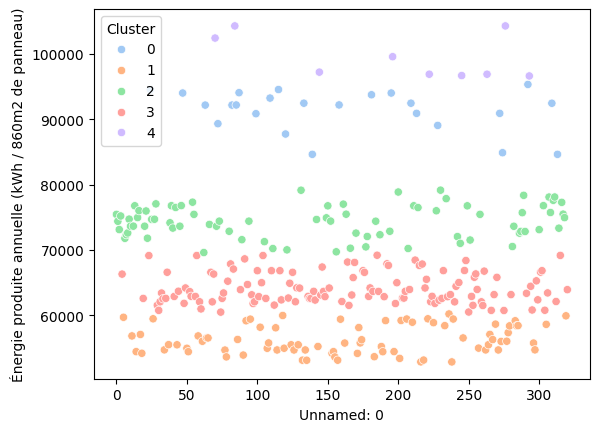

In [93]:
import seaborn as sns

sns.scatterplot(
    x= df['Unnamed: 0'] ,
    y= df['Énergie produite annuelle (kWh / 860m2 de panneau)'],
    hue = df['Cluster'],
    palette= 'pastel',
  )



In [94]:
def naming_cluster(number:int)-> str:
    number = str(number)
    if '0' in number :
        return "B"
    elif '1' in number :
        return "E"
    elif '2' in number:
        return "C"
    elif '3' in number:
        return "D"
    else :
        return "A"

In [95]:
df['SolarScore'] = df['Cluster'].apply(naming_cluster)

In [96]:
df.head()

,Unnamed: 0,Nom,Lien,Début,Fin,Distance,Type voie,Nature voie,Revêtement,Carte,Coordonnées de début,Coordonnées de fin,Coordonnées milieu,Énergie produite annuelle (kWh / m2 de panneau),Energie produite annuelle (kWh),Énergie produite annuelle (kWh / 860m2 de panneau),score,Cluster,SolarScore
0,0,Voie Verte du Chemin d’Encochebérot,https://www.af3v.org/les-voies-vertes/voies/12...,L ISLE JOURDAIN,L ISLE JOURDAIN,"1,6km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.09673702748082', '43.62109781579031')","('1.1131950619939002', '43.6267673096849')","(1.1049660447373602, 43.62393256273761)",87.74,87.74,75456.4,0.992871,2,C
1,1,Voie Verte du canal de Saint-Martory,https://www.af3v.org/les-voies-vertes/voies/12...,CUGNAUX,TOURNEFEUILLE,"2,1km",Voie verte lisse,voie verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.32295597087284', '43.5323431084653')","('1.3433622170553097', '43.55502022774329')","(1.333159093964075, 43.5436816681043)",86.51,86.51,74398.6,0.978952,2,C
2,2,Voie Verte de la Masse Pont-du-Casse-Agen,https://www.af3v.org/les-voies-vertes/voies/11...,PONT DU CASSE,AGEN,"2,3km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('0.6480315531906747', '44.216304129821')","('0.6696608866837562', '44.22602284001947')","(0.6588462199372155, 44.22116348492023)",85.03,85.03,73125.8,0.962204,2,C
3,3,Voie Verte des trois ponts Castelnau d’Estréte...,https://www.af3v.org/les-voies-vertes/voies/12...,CASTELNAU D ESTRETEFONDS,FRONTON,"3,2km",Voie verte lisse,Voie Verte,Enrobé,https://sig.af3v.org/index.php/view/embed/?rep...,"('1.35618301280646', '43.76616910015008')","('1.3659247959472003', '43.78084206988599')","(1.3610539043768302, 43.773505585018036)",87.45,87.45,75207.0,0.989589,2,C
4,4,Voie Verte des Berges de l'Ill à Mulhouse,https://www.af3v.org/les-voies-vertes/voies/13...,MULHOUSE,SAUSHEIM,"3,3km",Voie verte lisse,Canal,Enrobé lisse,https://sig.af3v.org/index.php/view/embed/?rep...,"('7.34639', '47.773977')","('7.362202', '47.79706')","(7.354296, 47.7855185)",77.10,77.10,66306.0,0.872468,3,D


In [97]:
df_solarscore = df[['Nom', 'SolarScore']]
df_solarscore

,Nom,SolarScore
0,Voie Verte du Chemin d’Encochebérot,C
1,Voie Verte du canal de Saint-Martory,C
2,Voie Verte de la Masse Pont-du-Casse-Agen,C
3,Voie Verte des trois ponts Castelnau d’Estréte...,C
4,Voie Verte des Berges de l'Ill à Mulhouse,D
...,...,...
316,V61 - Véloroute du Léman au Mont-Blanc : de Ge...,C
317,"Le Canal des deux mers à vélo (V80), en Tarn-e...",C
318,Véloroute Tour du Bassin d’Arcachon (EV1 Vélod...,C
319,Véloroute du Lin,E


In [98]:
df_solarscore.to_csv("df_solarscore.csv")

In [110]:
df[df['SolarScore']=='A']['score'].max()

np.float64(1.3726377729998869)